# Сборный проект-4

Поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.



## Описание данных





Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, os
from PIL import Image

In [71]:
!git clone https://github.com/gala-vision/project_15.git
%cd project_15/notebooks


Cloning into 'project_15'...
remote: Enumerating objects: 1130, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1130 (delta 5), reused 14 (delta 3), pack-reused 1114 (from 1)
Receiving objects: 100% (1130/1130), 143.34 MiB | 49.98 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Updating files: 100% (1110/1110), done.
/content/project_15/notebooks/project_15/notebooks/project_15/notebooks/project_15/notebooks/project_15/notebooks/project_15/notebooks


In [72]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))
src_path = os.path.join(os.getcwd(), os.pardir, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)
print("Путь к src:", src_path)


Путь к src: /content/project_15/notebooks/project_15/notebooks/project_15/notebooks/project_15/notebooks/project_15/notebooks/project_15/notebooks/../src


In [73]:
from src.utils import information_data
# , aggregate_expert_ratings

## 1. Исследовательский анализ данных

Датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи нужно эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Можно воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберем либо одну из них, либо объединим их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


### `train_queries`

In [74]:
data_path = os.path.join(os.getcwd(), os.pardir, 'data')
train_images_path = os.path.join(data_path, 'train_images')
test_images_path = os.path.join(data_path, 'test_images')

In [75]:
train_queries = pd.read_csv(os.path.join(data_path, 'train_dataset.csv'))

print('Тренировочные запросы', end='\n\n')
information_data(train_queries)

Тренировочные запросы

Первые десять строк датафрейма:


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
5,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
6,3155451946_c0862c70cb.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
7,3222041930_f642f49d28.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
8,343218198_1ca90e0734.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
9,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   image       5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB


None

Описание данных:


,image,query_id,query_text
count,5822,5822,5822
unique,1000,977,977
top,3364151356_eecd07a23e.jpg,2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a..."
freq,10,34,34


Количество пропусков:


,0
image,0
query_id,0
query_text,0


Количество дубликатов:


0

### `test_queries`

In [76]:
test_queries = pd.read_csv(os.path.join(data_path, 'test_queries.csv'), sep='|', index_col=0)

print('Тестовые запросы', end='\n\n')
information_data(test_queries)

Тестовые запросы

Первые десять строк датафрейма:


,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg
5,1232148178_4f45cc3284.jpg#0,A baby girl playing at a park .,1232148178_4f45cc3284.jpg
6,1232148178_4f45cc3284.jpg#1,A closeup of a child on a playground with adul...,1232148178_4f45cc3284.jpg
7,1232148178_4f45cc3284.jpg#2,A young boy poses for a picture in front of a ...,1232148178_4f45cc3284.jpg
8,1232148178_4f45cc3284.jpg#3,A young girl is smiling in front of the camera...,1232148178_4f45cc3284.jpg
9,1232148178_4f45cc3284.jpg#4,There is a little blond hair girl with a green...,1232148178_4f45cc3284.jpg


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB


None

Описание данных:


,query_id,query_text,image
count,500,500,500
unique,500,500,100
top,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
freq,1,1,5


Количество пропусков:


,0
query_id,0
query_text,0
image,0


Количество дубликатов:


0

Обе выборки (обучающая и тестовая) имеют одинаковую структуру – содержат три столбца: идентификатор запроса (query_id), текст запроса (query_text) и название изображения (image).

Тестовая выборка:

Состоит из 500 записей, все значения уникальны.
Пропусков и дубликатов нет, что обеспечивает чистоту данных для тестирования модели.

Обучающая выборка:

Включает 5822 записи.
Количество уникальных значений немного отличается: имеется 1000 уникальных изображений и 977 уникальных запросов.
Также не содержит пропусков или дубликатов, что гарантирует корректное обучение модели.
Таким образом, обе выборки структурно идентичны и готовы для дальнейшей обработки при обучении и тестировании модели.

In [90]:
crowd_df['image'] = crowd_df['query_id'].str.split('#').str[0]
expert_df['image'] = expert_df['query_id'].str.split('#').str[0]

# Проверяем, совпадают ли image и query_image
crowd_mismatch = crowd_df[crowd_df['image'] != crowd_df['image']]
expert_mismatch = expert_df[expert_df['image'] != expert_df['image']]

print(f'Несовпадения в CrowdAnnotations: {len(crowd_mismatch)}')
print(f'Несовпадения в ExpertAnnotations: {len(expert_mismatch)}')

# Проверяем, есть ли images, которых нет в query_id, и наоборот
unique_images_crowd = set(crowd_df['image'].unique())
unique_queries_crowd = set(crowd_df['image'].unique())
missing_images_crowd = unique_queries_crowd - unique_images_crowd

unique_images_expert = set(expert_df['image'].unique())
unique_queries_expert = set(expert_df['image'].unique())
missing_images_expert = unique_queries_expert - unique_images_expert

print(f'Изображений без query_id в CrowdAnnotations: {len(missing_images_crowd)}')
print(f'Изображений без query_id в ExpertAnnotations: {len(missing_images_expert)}')

Несовпадения в CrowdAnnotations: 0
Несовпадения в ExpertAnnotations: 0
Изображений без query_id в CrowdAnnotations: 0
Изображений без query_id в ExpertAnnotations: 0


### `crowd_df`

In [78]:
column_names = ['image', 'query_id', 'fraction_confirmed', 'num_confirmed', 'num_rejected']
crowd_df = pd.read_csv(os.path.join(data_path, 'CrowdAnnotations.tsv'), sep='\t', names=column_names,
                       header=0)

print('Краудсорсинговые оценки', end='\n\n')
information_data(crowd_df)


Краудсорсинговые оценки

Первые десять строк датафрейма:


,image,query_id,fraction_confirmed,num_confirmed,num_rejected
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.000000,0,3
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.000000,0,3
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.000000,0,3
3,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.000000,0,3
4,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.000000,0,3
5,1056338697_4f7d7ce270.jpg,2224450291_4c133fabe8.jpg#2,0.000000,0,3
6,1056338697_4f7d7ce270.jpg,2248487950_c62d0c81a9.jpg#2,0.333333,1,2
7,1056338697_4f7d7ce270.jpg,2307118114_c258e3a47e.jpg#2,0.000000,0,3
8,1056338697_4f7d7ce270.jpg,2309860995_c2e2a0feeb.jpg#2,0.000000,0,3
9,1056338697_4f7d7ce270.jpg,2436081047_bca044c1d3.jpg#2,0.000000,0,3


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   image               47829 non-null  object 
 1   query_id            47829 non-null  object 
 2   fraction_confirmed  47829 non-null  float64
 3   num_confirmed       47829 non-null  int64  
 4   num_rejected        47829 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


None

Описание данных:


,fraction_confirmed,num_confirmed,num_rejected
count,47829.000000,47829.000000,47829.000000
mean,0.068766,0.208430,2.820214
std,0.207490,0.628775,0.656556
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,3.000000
50%,0.000000,0.000000,3.000000
75%,0.000000,0.000000,3.000000
max,1.000000,5.000000,6.000000


Количество пропусков:


,0
image,0
query_id,0
fraction_confirmed,0
num_confirmed,0
num_rejected,0


Количество дубликатов:


0

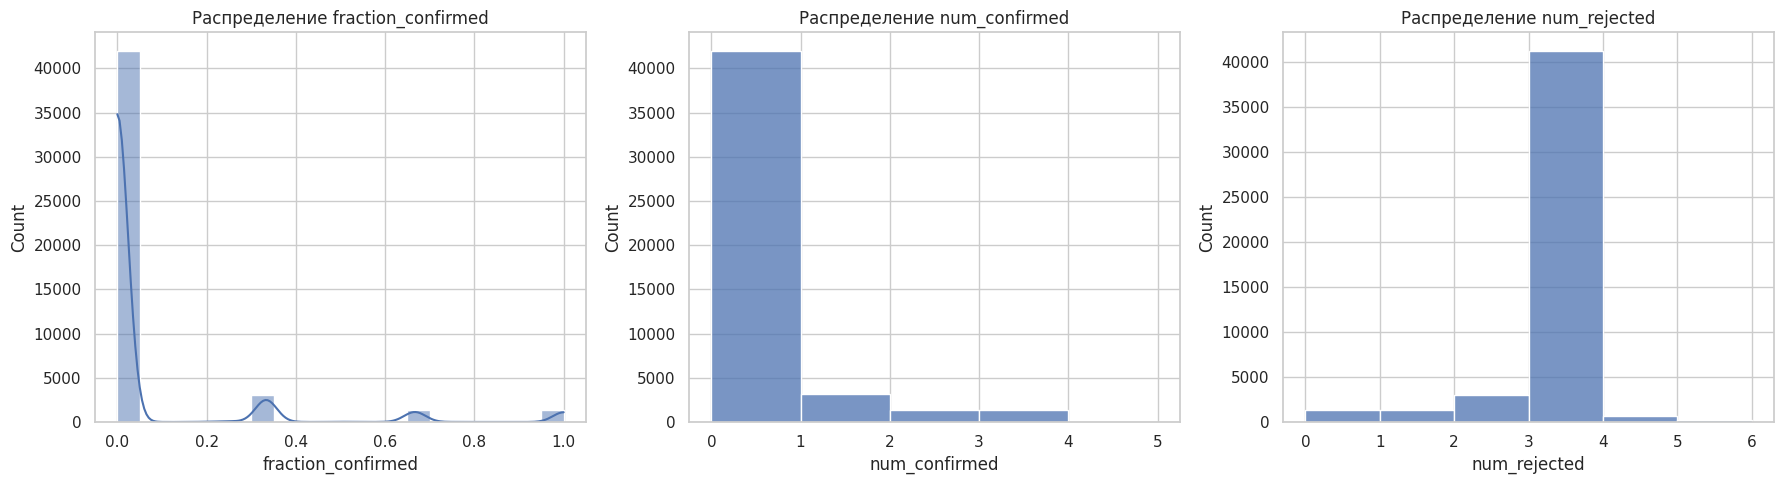

In [79]:
# Настройки графиков
sns.set(style="whitegrid")

# Графики для crowd_df
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(crowd_df['fraction_confirmed'], bins=20, kde=True, ax=axes[0])
axes[0].set_title('Распределение fraction_confirmed')

sns.histplot(crowd_df['num_confirmed'], bins=range(0, crowd_df['num_confirmed'].max() + 1), kde=False, ax=axes[1])
axes[1].set_title('Распределение num_confirmed')

sns.histplot(crowd_df['num_rejected'], bins=range(0, crowd_df['num_rejected'].max() + 1), kde=False, ax=axes[2])
axes[2].set_title('Распределение num_rejected')

plt.tight_layout()
plt.show()

### `expert_df`

In [80]:
column_names = ['image', 'query_id', 'expert_1', 'expert_2', 'expert_3']
expert_df = pd.read_csv(os.path.join(data_path, 'ExpertAnnotations.tsv'), sep='\t', names=column_names, header=0)

print('Оценки экспертов', end='\n\n')
information_data(expert_df)

Оценки экспертов

Первые десять строк датафрейма:


,image,query_id,expert_1,expert_2,expert_3
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,1,1,1
5,1056338697_4f7d7ce270.jpg,3545652636_0746537307.jpg#2,1,1,1
6,1056338697_4f7d7ce270.jpg,434792818_56375e203f.jpg#2,1,1,2
7,106490881_5a2dd9b7bd.jpg,1425069308_488e5fcf9d.jpg#2,1,1,1
8,106490881_5a2dd9b7bd.jpg,1714316707_8bbaa2a2ba.jpg#2,2,2,2
9,106490881_5a2dd9b7bd.jpg,2140182410_8e2a06fbda.jpg#2,2,2,2


Общая информация о датафрейме:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5821 entries, 0 to 5820
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image     5821 non-null   object
 1   query_id  5821 non-null   object
 2   expert_1  5821 non-null   int64 
 3   expert_2  5821 non-null   int64 
 4   expert_3  5821 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


None

Описание данных:


,expert_1,expert_2,expert_3
count,5821.000000,5821.000000,5821.000000
mean,1.436695,1.624463,1.882151
std,0.787130,0.856256,0.904091
min,1.000000,1.000000,1.000000
25%,1.000000,1.000000,1.000000
50%,1.000000,1.000000,2.000000
75%,2.000000,2.000000,2.000000
max,4.000000,4.000000,4.000000


Количество пропусков:


,0
image,0
query_id,0
expert_1,0
expert_2,0
expert_3,0


Количество дубликатов:


0

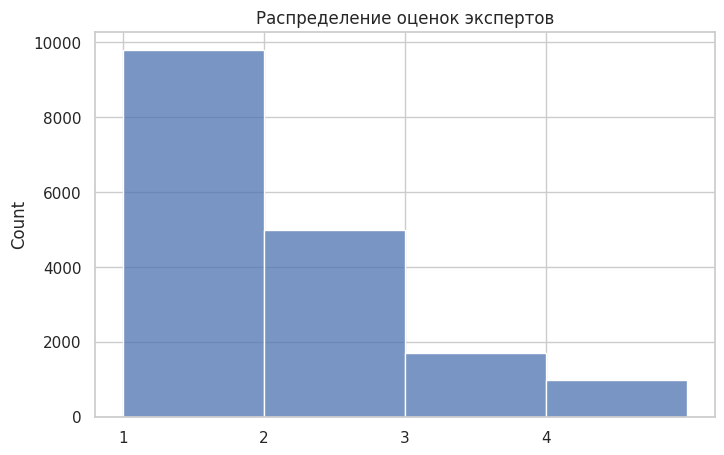

In [81]:
# Графики для expert_df
fig, ax = plt.subplots(figsize=(8, 5))

expert_scores = expert_df[['expert_1', 'expert_2', 'expert_3']].values.flatten()
sns.histplot(expert_scores, bins=range(1, expert_scores.max() + 2), kde=False)
ax.set_title('Распределение оценок экспертов')
ax.set_xticks(range(1, expert_scores.max() + 1))


Заключение по датасетам оценок:

В датасете краудсорсинговых оценок представлено 47 829 записей, каждая из которых содержит имя изображения, идентификатор описания и статистику подтверждения соответствия (доля подтверждений, число подтверждений и число отказов). Значения подтверждения в большинстве случаев равны нулю, что указывает на низкую согласованность оценок для большинства пар «изображение–описание».

В датасете экспертных оценок содержится 5 821 запись с тремя оценками от экспертов по шкале от 1 до 4. Экспертные оценки, в отличие от краудсорсинговых, характеризуются более высокой согласованностью и, в среднем, ниже значениями (близкими к минимальному порогу), что свидетельствует о строгом подходе экспертов к оценке соответствия.

Оба датасета не содержат пропусков и дубликатов, что гарантирует корректность данных для последующего анализа и обучения модели.

### `final_df`

Агрегируем оценки соответствия описаний изображениям следующим образом:
Агрегация оценок:

Для пар с экспертными оценками:
Рассчитать итоговую оценку по голосованию большинства, нормализовать её.
Рассчитать итоговую оценку как

$ 0.6 × $ `expert_norm`$ + 0.4 × $ `fraction_confirmed`

Для пар без экспертных оценок:
Использовать крауд-оценку с пониженным весом (например, оставить её как есть или скорректировать отдельно).

Объединение датасетов:

Соберем итоговую таблицу, где для каждой пары «изображение–описание» будет указана итоговая оценка. При этом, если требуется, можно добавить отдельные колонки для экспертных и крауд оценок как дополнительные признаки, но итоговая агрегированная оценка должна стать целевой переменной.

In [82]:
def aggregate_expert_ratings(row):
    ratings = [row['expert_1'], row['expert_2'], row['expert_3']]
    if len(set(ratings)) == 3:  # Если все три разные, считаем их противоречивыми и отбрасываем
        return None
    return sorted(ratings)[1]  # Медиана большинства

# 1. Агрегируем экспертные оценки
expert_df['expert_score'] = expert_df.apply(aggregate_expert_ratings, axis=1)
expert_df.drop(columns=['expert_1', 'expert_2', 'expert_3'], inplace=True)  # Удаляем исходные колонки
expert_df.dropna(subset=['expert_score'], inplace=True)  # Убираем строки с противоречивыми оценками

# 2. Нормализуем экспертные оценки (min=1, max=4 -> от 0 до 1)
expert_df['expert_score_norm'] = (expert_df['expert_score'] - 1) / 3

# 3. Объединяем датасеты
merged_df = pd.merge(crowd_df, expert_df, on=['image', 'query_id'], how='left')

# 4. Если есть обе оценки - берем взвешенное среднее
mask = (~merged_df['expert_score_norm'].isna()) & (~merged_df['fraction_confirmed'].isna())
merged_df.loc[mask, 'final_score'] = (
    0.6 * merged_df.loc[mask, 'expert_score_norm'] + 0.4 * merged_df.loc[mask, 'fraction_confirmed']
)

# 5. Если есть только одна из оценок, используем её
merged_df['final_score'] = merged_df['final_score'].combine_first(
    merged_df['expert_score_norm'].combine_first(merged_df['fraction_confirmed'])
)

# 6. Оставляем только нужные столбцы
final_df = merged_df[['image', 'query_id', 'final_score']]

Посмотрим на распределение таргета на гистограмме

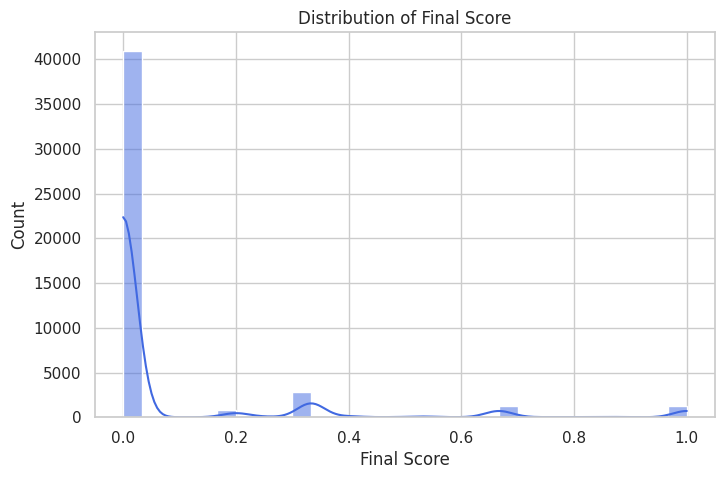

In [83]:
plt.figure(figsize=(8, 5))
sns.histplot(final_df['final_score'], bins=30, kde=True, color='royalblue')
plt.xlabel('Final Score')
plt.ylabel('Count')
plt.title('Distribution of Final Score')
plt.grid(True)
plt.show()


In [84]:
# Информация о данных
print(final_df.info())
print('Количество строк:', len(final_df))
print('Пропуски в данных:\n', final_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47829 entries, 0 to 47828
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   image        47829 non-null  object 
 1   query_id     47829 non-null  object 
 2   final_score  47829 non-null  float64
dtypes: float64(1), object(2)
memory usage: 1.1+ MB
None
Количество строк: 47829
Пропуски в данных:
 image          0
query_id       0
final_score    0
dtype: int64


Посмотрим несколько изображений и описаний к ним

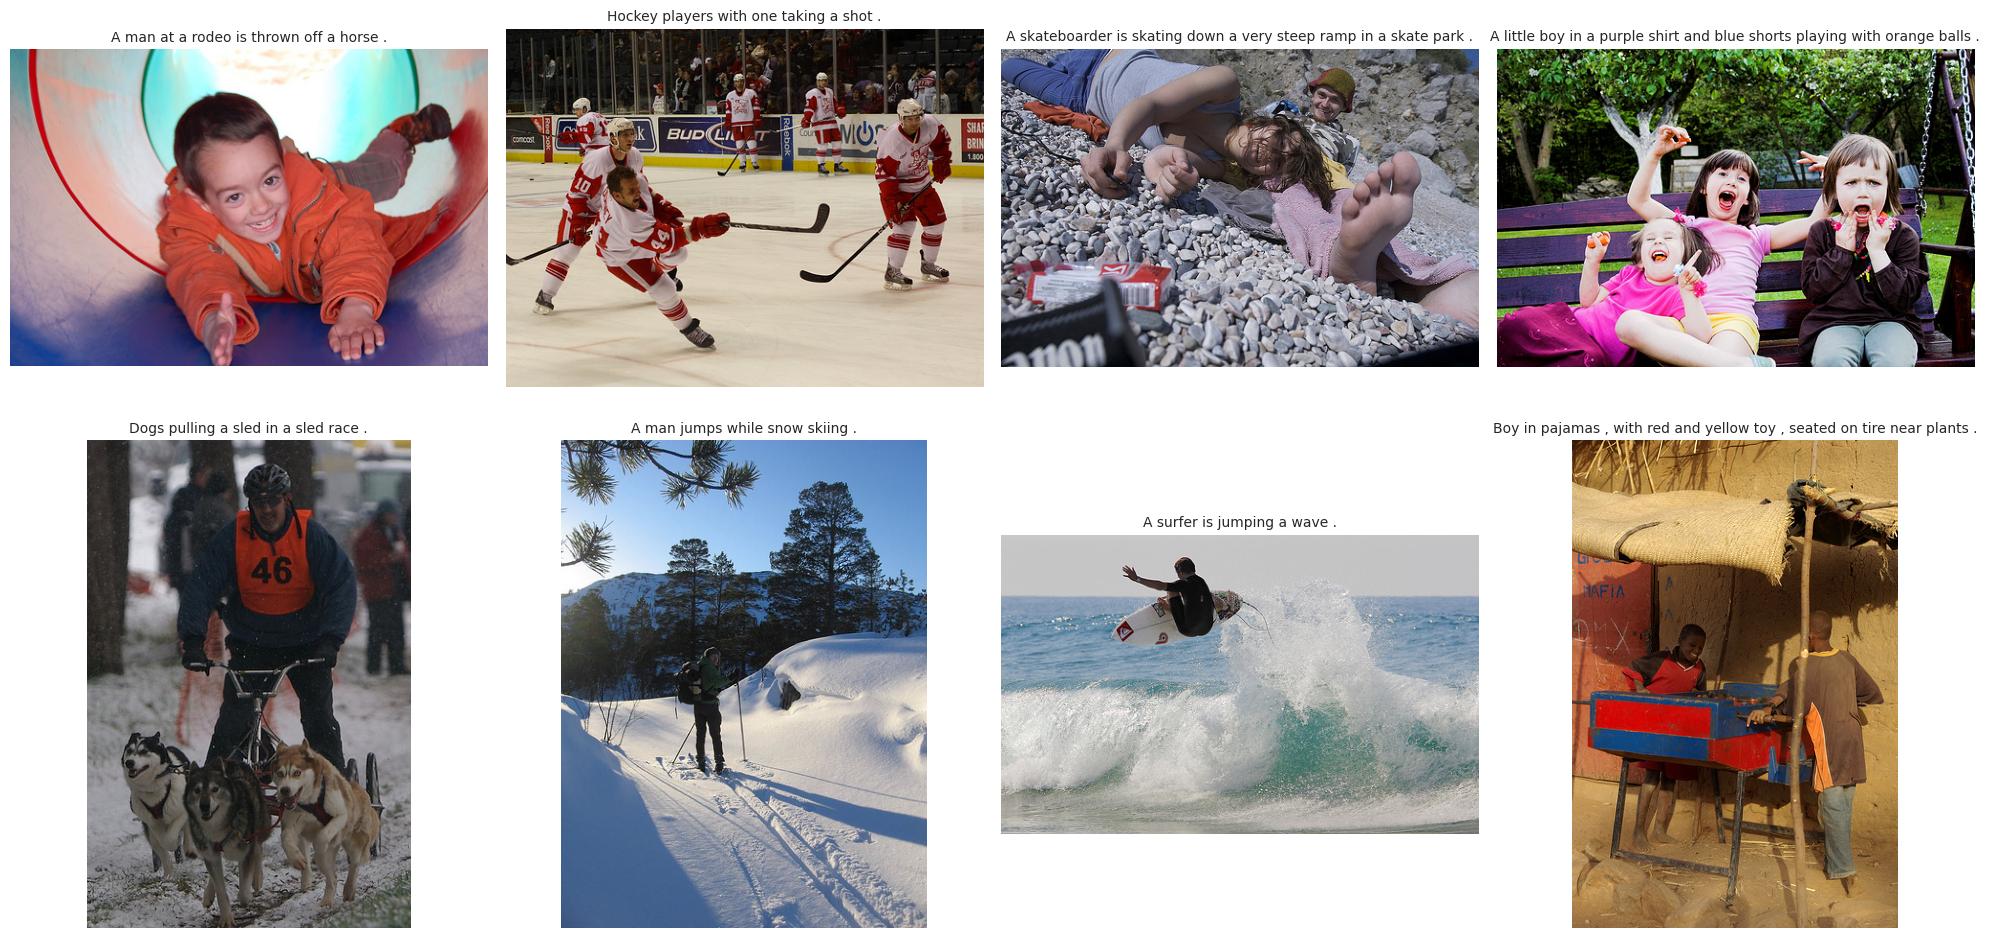

In [97]:
sample = train_queries.sample(8, random_state=42)  # Берем 5 случайных примеров

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, row in enumerate(sample.itertuples()):
    image_path = os.path.join(train_images_path, row.image)

    try:
        image = Image.open(image_path)
        axes[idx].imshow(image)
        axes[idx].axis("off")
        axes[idx].set_title(row.query_text, fontsize=10)
    except FileNotFoundError:
        print(f"Файл {row.image} не найден.")
        axes[idx].axis("off")

plt.tight_layout()
plt.show()

## 2. Проверка данных

В некоторых странах, где работает наша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В нашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у нас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, удалим из обучающей выборки.

## 3. Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

## 4. Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


## 5. Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

## 6. Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

## 7. Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

## 8. Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска